# 統計モデルでシグモイド+線形の合成関数の切り替え点を求める


In [1]:
import cmdstanpy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cmdstanjupyter
import arviz
plt.style.use("ggplot")

/home/takato/stanenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cmdstanpy.install_cmdstan()

CmdStan install directory: /home/takato/.cmdstan
CmdStan version 2.36.0 already installed
Test model compilation


True

In [6]:
%load_ext cmdstanjupyter

In [402]:
df = pd.read_parquet("../../customdataset/accum_curve_linear_dataset.parquet")

In [403]:
df

,x,y,phase,hour,p_sat
0,0,0.008790,sigmoid,0,150.0
1,1,0.008790,sigmoid,0,150.0
2,2,0.008790,sigmoid,0,150.0
3,3,0.008790,sigmoid,0,150.0
4,4,0.008790,sigmoid,0,150.0
...,...,...,...,...,...
496,496,16.039180,linear,23,194.0
497,497,16.113800,linear,23,194.0
498,498,16.113800,linear,23,194.0
499,499,16.160819,linear,23,194.0


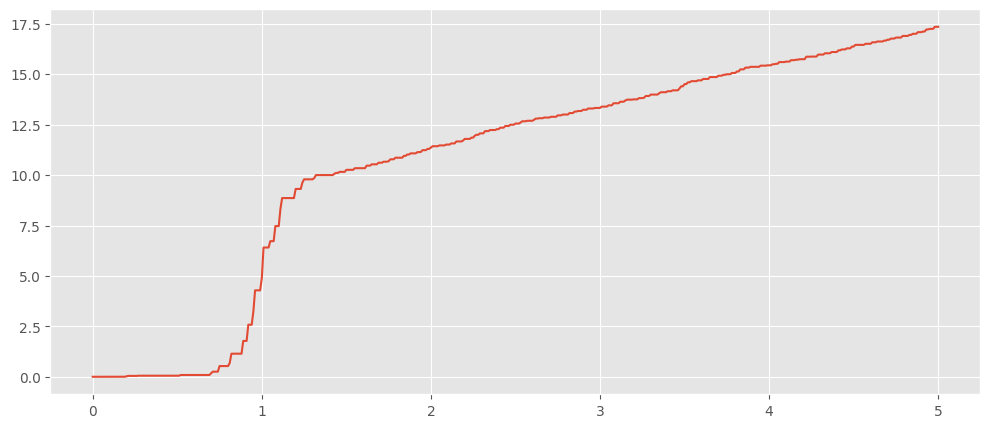

In [404]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_sel["x_scale"], df_sel["y"])

In [ ]:
%%stan sigmoid_linear
data {
    int N_X;
    vector[N_X] X;
    vector[N_X] y_price;           // 0..10 を想定
}
parameters {
    real<lower=5,upper=15> a;
    real<lower=0,upper=1.1> x0;  // シグモイド区間の変曲点
    real<lower=1e-6> sigma_y;      // 0 を避ける
    real<lower=1e-6,upper=1> delta;        // 中腹幅の下限（要調整）
    real<lower=1,upper=5> x1;
    real<lower=0.1,upper=5> alpha;
}
transformed parameters {
    real k = (2.0 * log(9)) / delta;
}
model {
    // 弱情報の事前（必要に応じて調整）
    a       ~ normal(9, 5);               // 上下限が 0..10 なら a≃10 付近
    sigma_y ~ normal(0, 1);
    vector[N_X] mu;
    mu =  a*inv_logit(k*(X-x0)) +  inv_logit(10*(X-x1)).*(alpha*(X-x1));
    y_price ~ normal(mu, sigma_y);
  }

generated quantities {
    vector[N_X] y_new;
    vector[N_X] mu_new;
   
    for (n in 1:N_X)
    {
        mu_new[n] = a/(1+exp(-k*(X[n]-x0))) + 1/(1+ exp(-10*(X[n]-x1)))* (alpha*(X[n]-x1));
        y_new[n] = normal_rng(mu_new[n], sigma_y);
    }
}

INFO:cmdstanjupyter:Creating CmdStanPy model & assigning it to variable "sigmoid_linear"
02:38:24 - cmdstanpy - INFO - compiling stan file /home/takato/Git/pr_cmdstan/NoteBook/accum_curve_fitting/.stan/sigmoid_linear.stan to exe file /home/takato/Git/pr_cmdstan/NoteBook/accum_curve_fitting/.stan/sigmoid_linear
02:38:45 - cmdstanpy - INFO - compiled model executable: /home/takato/Git/pr_cmdstan/NoteBook/accum_curve_fitting/.stan/sigmoid_linear
INFO:cmdstanjupyter:StanModel now available as variable "sigmoid_linear"!
 Compilation took 21 seconds.


In [453]:
df_sel = df[df["hour"].isin([0,1,2,3,4,5,6])]

In [454]:
df_sel["x_scale"] = df_sel["x"] /100
df_sel

/tmp/ipykernel_3345/354240167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel["x_scale"] = df_sel["x"] /100


,x,y,phase,hour,p_sat,x_scale
0,0,0.008790,sigmoid,0,150.0,0.00
1,1,0.008790,sigmoid,0,150.0,0.01
2,2,0.008790,sigmoid,0,150.0,0.02
3,3,0.008790,sigmoid,0,150.0,0.03
4,4,0.008790,sigmoid,0,150.0,0.04
...,...,...,...,...,...,...
496,496,17.058627,linear,6,178.0,4.96
497,497,17.058627,linear,6,178.0,4.97
498,498,17.058627,linear,6,178.0,4.98
499,499,17.058627,linear,6,178.0,4.99


In [455]:
data = {
    "N_X":len(df_sel),
    "X":df_sel["x_scale"].values,
    "y_price":df_sel["y"].values
}

In [456]:
fit = sigmoid_linear.sample(data=data,  chains=4, iter_warmup=1000, iter_sampling=1000,seed=1234, adapt_delta=0.99)

03:10:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                                 | 00:00 Status
chain 2 |                                                                                                 | 00:00 Status

chain 3 |                                                                                                 | 00:00 Status


chain 4 |                                                                                                 | 00:00 Status


chain 4 |█████▊                                                          | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█████▊                                                          | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |████████▋                                                       | 00:04 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |███████████▋                                                    | 00:05 Iteration:


03:11:54 - cmdstanpy - INFO - CmdStan done processing.


In [457]:
dfres = fit.summary()
dfres.head(10)

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,1840.800000,36.440800,51.633800,76.613400,1786.870000,1838.550000,1894.200000,6.11628,2000.00,1.735840
a,9.451680,0.443645,0.628842,0.926247,8.789890,9.487460,10.113300,6.12901,2000.00,1.736200
x0,0.985071,0.012287,0.017441,0.025789,0.966096,0.985280,1.004190,6.11630,2000.00,1.735900
sigma_y,0.358266,0.003750,0.006658,0.007519,0.347708,0.358121,0.368916,7.17093,2000.00,1.532260
delta,0.444704,0.023765,0.033928,0.049858,0.405184,0.445753,0.484508,6.10849,2000.00,1.734990
x1,1.346900,0.235002,0.333052,0.494996,1.002010,1.363430,1.698070,6.11910,2000.00,1.736270
alpha,2.037380,0.014667,0.021720,0.030445,2.008320,2.035450,2.067150,6.15834,2000.00,1.733530
k,9.939590,0.531322,0.758762,1.101480,9.069920,9.869340,10.845500,6.10848,2000.00,1.734990
y_new[1],-0.000899,0.005998,0.362367,0.371353,-0.597393,-0.004448,0.591002,3716.45000,3695.86,0.999711
y_new[2],-0.008901,0.005597,0.360950,0.360766,-0.617797,-0.000501,0.581238,4196.84000,3936.93,1.000080


In [458]:
df_res = dfres.filter(like="y_new",axis=0)
df_res

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
y_new[1],-0.000899,0.005998,0.362367,0.371353,-0.597393,-0.004448,0.591002,3716.45,3695.86,0.999711
y_new[2],-0.008901,0.005597,0.360950,0.360766,-0.617797,-0.000501,0.581238,4196.84,3936.93,1.000080
y_new[3],0.001404,0.005573,0.358410,0.359589,-0.588586,-0.000240,0.598045,4143.37,4001.61,0.999857
y_new[4],-0.000379,0.005952,0.357850,0.360847,-0.582860,0.002743,0.580858,3605.27,4060.07,1.001350
y_new[5],0.003669,0.005750,0.362005,0.364833,-0.586797,0.005834,0.594388,3973.07,3878.45,1.001190
...,...,...,...,...,...,...,...,...,...,...
y_new[3503],16.810300,0.005696,0.361872,0.355379,16.213900,16.811300,17.402000,4088.90,3897.51,1.001390
y_new[3504],16.827500,0.005858,0.359932,0.357381,16.236800,16.826000,17.419400,3823.78,3655.41,1.001670
y_new[3505],16.846000,0.005751,0.349821,0.348485,16.262600,16.845500,17.414300,3732.84,3804.54,1.001920
y_new[3506],16.866100,0.005633,0.359250,0.352118,16.267600,16.871900,17.462200,4092.34,3848.64,1.002850


In [459]:
df_sel["pred_Mean"] = df_res.filter(like="y_new",axis=0)["Mean"].values
df_sel["pred_5%"] = df_res.filter(like="y_new",axis=0)["5%"].values
df_sel["pred_95%"] = df_res.filter(like="y_new",axis=0)["95%"].values

/tmp/ipykernel_3345/8020210.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel["pred_Mean"] = df_res.filter(like="y_new",axis=0)["Mean"].values
/tmp/ipykernel_3345/8020210.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel["pred_5%"] = df_res.filter(like="y_new",axis=0)["5%"].values
/tmp/ipykernel_3345/8020210.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

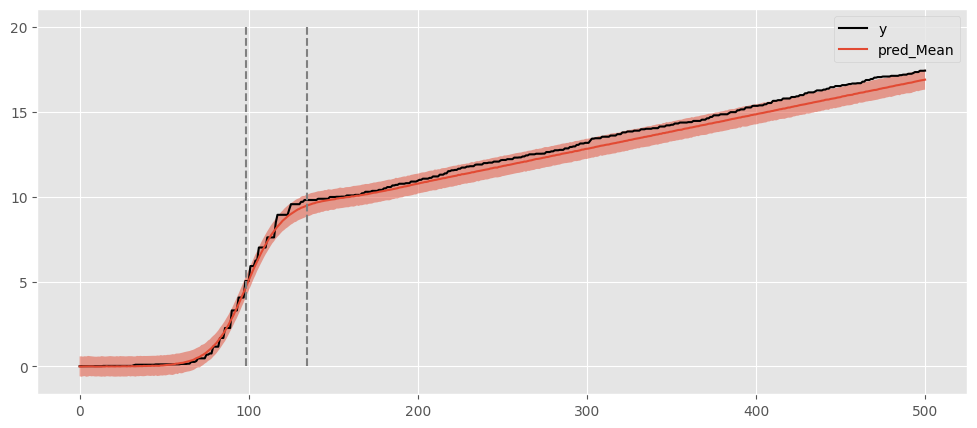

In [472]:
df_sel2 = df_sel.query("hour==3")
fig,ax = plt.subplots(figsize=(12,5))
df_sel2[["y","pred_Mean"]].plot(ax=ax,color=["k","C0"])
ax.fill_between(df_sel2.index,df_sel2["pred_95%"], df_sel2["pred_5%"],alpha=0.5)
ax.vlines(dfres.loc["x0","Mean"]*100,0,20,color="gray",ls="--")
ax.vlines(dfres.loc["x1","Mean"]*100,0,20, color="gray",ls="--")